## Opis problema

Svake godine, približno 7.6 miliona kućnih ljubimaca završi u azilima širom Amerike. Dosta životinja vlasnici više ne žele, a ostale se spašavaju sa ulice. Mnoge životinje pronađu novi dom, ali nažalost ne i sve. Preko 2.7 miliona pasa i mačaka se uspavljuje svake godine u Americi.

Naš zadatak je da koristeći skup podataka o životinjama od strane Austin Animal Center koji sadrži informacije poput rase, boje, pola i starosti životinja predvidimo sudbinu svake životinje.



Za svaku životinju i svaku sudbinu treba da izračunamo verovatnoću da životinja ima tu sudbinu:

```
AnimalID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
A715022,1,0,0,0,0
A677429,0.5,0.3,0.2,0,0
...
etc.
```

Moguće sudbine, odnosno ishodi, su:
- Adoption (životinja je pronašla novi dom)
- Died (životinja je nažalost preminula)
- Euthanasia (životinja je nažalost uspavana)
- Return_to_owner (životinja je vraćena svom vlasniku)
- Transfer (životinja je premeštena u drugi azil)

Rešenje će se ocenjivati takozvanom multi-class logarithmic loss funkcijom:

$logloss = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \log_e{(p_{ij})}$

$N$ predstavlja broj životinja u skupu podataka koji se koristi za testiranje, $M$ broj mogućih sudbina, $log_e$ prirodni logiram, $y_{ij}$ ima vrednost $1$ ukoliko је životinju $i$ zadesila sudbina $j$, a u suprotnom ima vrednost $0$ i $p_{ij}$ predstavlja verovatnoću koju smo mi izračunali.

Jasno je da bolje rešenje ima manju vrednost funkcije $logloss$, dakle funkciju $logloss$ je potrebno minimizovati.


## Učitavanje potrebnih Python paketa

In [32]:
# Pandas/Matplotlib/NumPy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# SciKeras
from scikeras.wrappers import KerasClassifier

# Scikit-Learn classifiers
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Scikit-Learn cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Učitavanje, analiza i preprocesiranje podataka

In [3]:
# Skup podataka za treniranje modela
train_df = pd.read_csv('train.csv')
# Skup podataka za testiranje modela
test_df = pd.read_csv('test.csv')

train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
train_df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A671945,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


### Sudbina ljubimaca

Najčešći ishodi u skupu podataka za treniranje algoritama su usvajanje, transfer, kao i vraćanje izgubljenih kućnih ljubimaca vlasnicima.

Text(0.5, 0, 'Ishodi kućnih ljubimaca u trening skupu podataka')

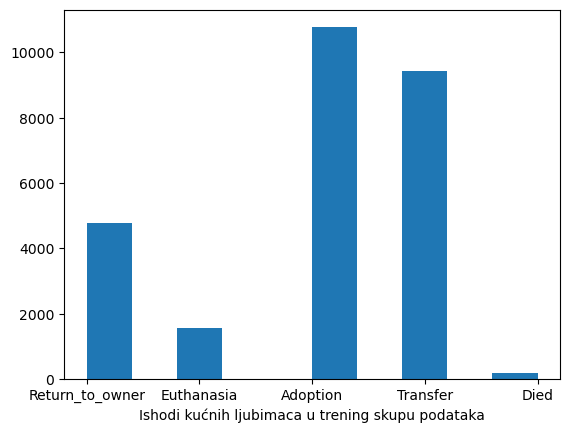

In [6]:
train_df['OutcomeType'].hist(grid=False)
plt.xlabel('Ishodi kućnih ljubimaca u trening skupu podataka')

### Starost ljubimaca

Možemo videti da je kolona `AgeuponOutcome` znakovnog tipa, pa ćemo je konvertovati u numerički tip kako bi smo mogli da je korisitmo u našim modelima.

In [7]:
train_df.AgeuponOutcome.value_counts()[:10]

AgeuponOutcome
1 year      3969
2 years     3742
2 months    3397
3 years     1823
1 month     1281
3 months    1277
4 years     1071
5 years      992
4 months     888
6 years      670
Name: count, dtype: int64

In [8]:
# Funkcija koja pretvara znakovnu vrednost starosti u numeričku vrednost (sstarost u danima)
def convert_age_upon_outcome_to_numerical_value(age_upon_outcome):
    parts = age_upon_outcome.split()
    value = int(parts[0])
    if 'year' in age_upon_outcome:
        return value * 365
    elif 'weeks' in age_upon_outcome:
        return value * 7
    elif 'month' in age_upon_outcome:
        return value * 30
    elif 'days' in age_upon_outcome:
        return value

    return value

Redove gde ne znamo starost životinje ćemo popuniti nulama.

In [9]:
train_df['AgeuponOutcome'] = train_df['AgeuponOutcome'].fillna('0')

In [10]:
AgeInDays = train_df.AgeuponOutcome.transform(convert_age_upon_outcome_to_numerical_value)

train_df['AgeInDays'] = AgeInDays
train_df.drop(columns=['AgeuponOutcome'], inplace=True)
train_df['AgeInDays'].isnull().sum()

0

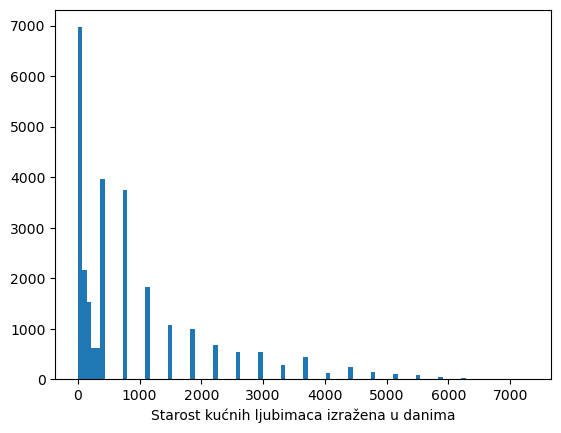

In [15]:
train_df['AgeInDays'].hist(bins=100, grid=False)
plt.xlabel('Starost kućnih ljubimaca izražena u danima');

Zaključujemo da je velika većina ljubimaca veoma mlada, mlađa od jedne godine.

### Boja životinja

In [16]:
train_df.Color.value_counts()[:10]

Color
Black/White          2824
Black                2292
Brown Tabby          1635
Brown Tabby/White     940
White                 931
Brown/White           884
Orange Tabby          841
Tan/White             773
Tricolor              752
Blue/White            702
Name: count, dtype: int64

### Rasa životinja

In [17]:
train_df.Breed.value_counts()[:10]

Breed
Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: count, dtype: int64

Možemo zaključiti da su najčešći rase životinja u našem skupu podataka takozvani "mešanci".

### Pol životinja

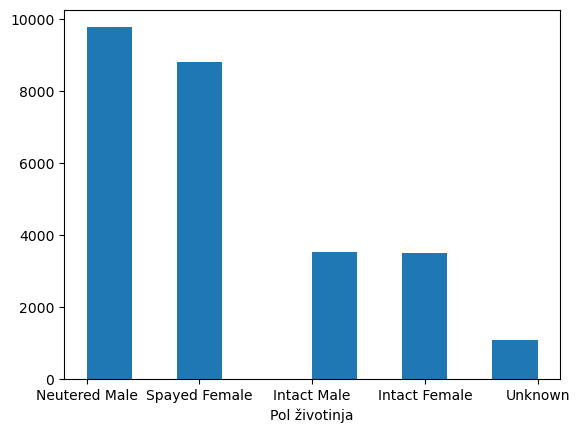

In [18]:
train_df.SexuponOutcome.hist(grid=False)
plt.xlabel('Pol životinja');

### Enkodovanje ulaznih podataka

In [19]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,AgeInDays
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,365
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,365
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,730
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,21
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,730


Možemo primetiti da dosta naših atributa (features) jesu znakovnog tipa, na primer:
- Breed (rasa)
- Color (boja)
- AnimalType (pas ili mačka)

Rad sa znakovnim podacima nije pogodan za algoritme mašinskog učenja i njima moramo pronaći neku numeričku vrednost. Najjednostavniji način za to je da se iskoristi klasa `LabelEncoder` iz paketa `sklearn.preprocessing` koja ulazni skup od $N$ različitih znakovnih vrednosti transformiše u skup čiji elementi pripadaju skupu $\{0, \dots, N-1\}$.

Naravno, naše enkodere moramo kreirati koristeći uniju skupova podataka za treniranje i testiranje kako bi smo obuhvatili sve moguće vrednosti.

In [20]:
# Kreiranje enkodera
encoder_training_data = pd.concat([train_df, test_df])

# Boja
color_encoder = LabelEncoder()
color_encoder.fit(encoder_training_data.Color)

# Rasa
breed_encoder = LabelEncoder()
breed_encoder.fit(encoder_training_data.Breed)

# Tip životinje
animal_type_encoder = LabelEncoder()
animal_type_encoder.fit(encoder_training_data.AnimalType)

# Pol
sex_upon_outcome_encoder = LabelEncoder()
sex_upon_outcome_encoder.fit(encoder_training_data.SexuponOutcome)

# Ishod
outcome_type_encoder = LabelEncoder()
outcome_type_encoder.fit(encoder_training_data.OutcomeType)

# Pod-ishod
outcome_subtype_encoder = LabelEncoder()
outcome_subtype_encoder.fit(encoder_training_data.OutcomeSubtype)

# Ime
name_encoder = LabelEncoder()
name_encoder.fit(encoder_training_data.Name);

Naše ulazne karakteristike ćemo dopuniti sa nekoliko novih kao što su:
- is_mix (da li je životinja "mešanac")
- year (godina)
- month (mesec)
- day (dan)

Karakteristiku `DateTime` ćemo podeliti u 3 dela (godina, mesec i dan) kako bi smo pokušali da uočimo korelaciju između ishoda i dana u godini (na primer, ljudi možda češće usvajaju životinje u prazničnoj atmosferi).

In [21]:
# Enkodovanje skupa podataka za treniranje modela
train_df.Color = color_encoder.transform(train_df.Color)
train_df['is_mix'] = train_df.Breed.apply(lambda x: 1 if 'Mix' in x else 0)
train_df.Breed = breed_encoder.transform(train_df.Breed)
train_df.AnimalType = animal_type_encoder.transform(train_df.AnimalType)
train_df.SexuponOutcome = sex_upon_outcome_encoder.transform(train_df.SexuponOutcome)
train_df.OutcomeType = outcome_type_encoder.transform(train_df.OutcomeType)
train_df.OutcomeSubtype = outcome_subtype_encoder.transform(train_df.OutcomeSubtype)
train_df.Name = name_encoder.transform(train_df.Name)
train_df['year'] = train_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
train_df['month'] = train_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
train_df['day'] = train_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)

train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,AgeInDays,is_mix,year,month,day
0,A671945,2910,2014-02-12 18:22:00,3,16,1,2,1482,146,365,1,2014,2,12
1,A656520,2265,2013-10-13 12:44:00,2,15,0,3,775,184,365,1,2013,10,13
2,A686464,5500,2015-01-31 12:28:00,0,6,1,2,1293,97,730,1,2015,1,31
3,A683430,7968,2014-07-11 19:09:00,4,12,0,1,775,47,21,1,2014,7,11
4,A667013,7968,2013-11-15 12:52:00,4,12,1,2,1101,311,730,0,2013,11,15


In [22]:
X = train_df.drop(['DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalID'], axis=1)
y = train_df.OutcomeType

### Poređenje modela mašinskog učenja

Sada ćemo porediti nekoliko modela mašinskog učenja koristeći unakrsnu validaciju. Modeli koji su nam interesantni jesu:
- RandomForestClassifier
- DecisionTreeClassifier
- ExtraTreesClassifier
- GradientBoostingClassifier
- Deep learning neural network model (Keras Sequential Model)

Koristićemo pomoćne funkcije paketa `sklearn.model_selection`:
- cross_val_score (koja radi unakrsnu validaciju)
- means (koja vraća ocenu modela)

Funkcija means u zavisnosti od modela koji ocenjuje koristi odgovarajuću metodu za računanju ocene:
- MSE (mean squared error)
- R2 (r squared)

### RandomForestClassifier

In [23]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.6219463246258797

### DecisionTreeClassifier

In [24]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.551984635181808

### ExtraTreesClassifier

In [25]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.6140521313330793

### GradientBoostingClassifier

In [26]:
clf = GradientBoostingClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.628942384381528

### Deep learning neural network

U ovom modelu kreiramo neuralnu mrežu sa jednim skrivenim slojem koji sadrži 16 neurona.

In [27]:
# Kreiranje skupova podataka za treniranje i testiranje od ulaznog skupa podataka
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2256, stratify=y) #2256 - Acko :)

In [28]:
# Normalizacija ulaznog skupa
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [29]:
# Primena OneHotEncoder kako bi smo znakovne atribute pretvorili u numeričke
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

In [30]:
# Kreiranje sekvencijalnog modela
def model_func():
    model=Sequential()  
    
    # Ulazni skup i prvi skriveni sloj 
    model.add(Dense(units=16, activation='relu', input_shape=(X_train_sc.shape[1],)))
    
    # Izlazni sloj
    model.add(Dense(5, activation='softmax'))
    
    # Kompajliranje modela
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [33]:
neural_network = KerasClassifier(model=model_func, epochs=10, batch_size=256, verbose=0)

In [ ]:
# Nalaženje hiperparametara neuralne mreže koristeći GridSearch algoritam
grid_search_neural_network = GridSearchCV(estimator=neural_network, param_grid={}, cv=3)
results = grid_search_neural_network.fit(X_train_sc, y_train_nn)

In [ ]:
print(grid_search_neural_network.best_score_)
# 0.59

### Odabir modela

Zaključujemo da model koji se ponaša najbolje nad našem skupu podataka jeste `GradientBoostingClassifier` tako da ćemo njega koristiti za konačno rešenje, ali ćemo povećati parametar n_estimators koji predstavlja koliko drveća naš model pravi pre nego što radi takozvano većinsko glasanje (ili računanje proseka) kako bi napravio predviđanje.

Ovo će učiniti naš kod sporijim, ali će dati bolje rešenje.

In [36]:
clf = GradientBoostingClassifier(n_estimators=500)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.6488460253016952

In [37]:
X.head()

,Name,AnimalType,SexuponOutcome,Breed,Color,AgeInDays,is_mix,year,month,day
0,2910,1,2,1482,146,365,1,2014,2,12
1,2265,0,3,775,184,365,1,2013,10,13
2,5500,1,2,1293,97,730,1,2015,1,31
3,7968,0,1,775,47,21,1,2014,7,11
4,7968,1,2,1101,311,730,0,2013,11,15


In [38]:
clf.fit(X, y)
clf.feature_importances_

array([0.14168256, 0.04001523, 0.44504199, 0.05654333, 0.02099925,
       0.25357824, 0.00169   , 0.0055234 , 0.01443525, 0.02049076])

Uočavamo da su najbitnije karakteristike ime, pol i starost životinje.

### Priprema podataka za testiranje

Na potpuno identičan način transformišemo starost životinja iz skupa podataka za testiranje kao i starost životinja iz skupa podataka za treniranje modela.

In [39]:
test_df['AgeuponOutcome'] = test_df['AgeuponOutcome'].fillna('0')

AgeInDays = test_df.AgeuponOutcome.transform(convert_age_upon_outcome_to_numerical_value)

test_df['AgeInDays'] = AgeInDays
test_df.drop(columns=['AgeuponOutcome'], inplace=True)
test_df['AgeInDays'].isnull().sum()

0

Kao i ostale karakteristike:

In [40]:
test_df.Color = color_encoder.transform(test_df.Color)
test_df['is_mix'] = test_df.Breed.apply(lambda x: 1 if 'Mix' in x else 0)
test_df.Breed = breed_encoder.transform(test_df.Breed)
test_df.AnimalType = animal_type_encoder.transform(test_df.AnimalType)
test_df.SexuponOutcome = sex_upon_outcome_encoder.transform(test_df.SexuponOutcome)
test_df.Name = name_encoder.transform(test_df.Name)
test_df['year'] = test_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
test_df['month'] = test_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
test_df['day'] = test_df.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)

In [41]:
test_df.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,Breed,Color,AgeInDays,is_mix,year,month,day
0,1,6995,2015-10-12 12:15:00,1,0,1023,283,300,1,2015,10,12
1,2,1368,2014-07-26 17:59:00,1,3,875,40,730,0,2014,7,26
2,3,2871,2016-01-13 12:20:00,0,2,775,117,365,1,2016,1,13
3,4,5728,2013-12-28 18:12:00,1,1,658,346,120,1,2013,12,28
4,5,6679,2015-09-24 17:59:00,1,2,1165,359,730,1,2015,9,24


## Formatiranje rešenja za predaju na platformi Kaggle

In [42]:
test_X = test_df.drop(['ID', 'DateTime'], axis=1)
test_y = clf.predict_proba(test_X)

results = []
for i in range(len(test_y)):
    row = {
        'ID': i + 1
    }
    
    for j in range(5):
        outcome = outcome_type_encoder.inverse_transform([j])[0]
        row[outcome] = test_y[i][j]
        
    results.append(row)
    
submission = pd.DataFrame(results)
submission

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.059791,0.001598,0.026272,0.302280,0.610059
1,2,0.598762,0.000768,0.017963,0.292022,0.090485
2,3,0.607851,0.001659,0.009157,0.103572,0.277762
3,4,0.178967,0.002061,0.032348,0.105406,0.681218
4,5,0.555040,0.000438,0.006393,0.309551,0.128577
...,...,...,...,...,...,...
11451,11452,0.854233,0.001422,0.009736,0.009343,0.125267
11452,11453,0.001180,0.017924,0.023092,0.002356,0.955448
11453,11454,0.004865,0.007132,0.085866,0.007838,0.894299
11454,11455,0.296556,0.000772,0.021601,0.590303,0.090768


In [43]:
submission.to_csv("submission.csv", index=False)

## Zaključak

Naš model ima rezultat 0.86337 na platformi Kaggle koji je sasvim prihvatljiv. Međutim lako je uočiti gde je naš model ima mesta za unapređenje:

Imamo dosta različitih rasa i boja životinja u našem skupu podataka i vidimo da one nisu najdominantnije karakteristike našeg modela. Razlog je to što veliki broj tih karakteristika možemo kodirati jednom, ali za to nam je potreban dodatan skup podataka koji bi nam dao kontekst o tome koje su rase slične.

Na primer, možemo više vrsti labradora ili retrivera predstaviti samo jednom (labrador, ili retriver), kao i više sličnih boja predstaviti jednom bojom. To bi malo smanjilo prostor pretrage i verovatno dalo bolje rezultate na kraju.